    Проект "Python Advanced. Функции. Домашнее задание (HW)"
ЗАДАЧА
Для закрепления пройденного материала предлагаем вам следующее задание: используя библиотеку kaggle-environments, реализующую функционал взаимодействия между виртуальными агентами в рамках нескольких популярных игр, реализовать самостоятельно несколько агентов и сравнить их в игре «камень-ножницы-бумага».

НЕОБХОДИМО:
Описать поведение бота, который будет играть с такими же ботами в игру «камень-ножницы-бумага». Поведение бота описывается с помощью функции, которая принимает на вход информацию о прошлых играх. (сигнатура функции приведена в Google Colab, а детальное описание входящих значений доступно по ссылке)
После описания поведения агентов запустить турнир между ними и проверить, какая стратегия показывает себя лучше всех.
Отметим, что вам необязательно использовать «качественные» стратегии — в этом задании основной упор необходимо сделать на разнообразие (т.е. агенты, которые бы играли, придерживаясь стратегии «только камень» или »только ножницы» – это нормально).

Установка kaggle_environments

In [1]:
!pip install -q -U kaggle_environments

Импорт необходимых библиотек

In [2]:
import kaggle_environments
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_environments import make, evaluate

Создаем объект для проведения испытаний

In [3]:
env = make(
    "rps",
    configuration={
        "episodeSteps": 100,
    }
)

Пишем различных ботов в файлы .ру Описание ботов ниже

In [4]:
%%writefile rock.py

def rock(observation, configuration):
    """
    Агент выбрасывет только камень
    """
    return 0

Overwriting rock.py


In [5]:
%%writefile paper.py

def paper(observation, configuration):
    """
    Агент выбрасывет только бумагу
    """
    return 1

Overwriting paper.py


In [6]:
%%writefile scissors.py

def scissors(observation, configuration):
    """
    Агент выбрасывет только ножницы
    """
    return 2

Overwriting scissors.py


In [7]:
%%writefile copy_opponent.py
import random

def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Overwriting copy_opponent.py


In [8]:
%%writefile last_react.py
import random

def last_react(observation, configuration):
    """
    Агент выбрасывает знак, чтобы переиграть предыдыущий  ход соперника 
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    else:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Overwriting last_react.py


In [9]:
%%writefile not_last.py

import random

def not_last(observation, configuration):
    """
    Агент выбрасывает случайный знак, отличный от своего предыдущего
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    else:
        if last_react_action == 0:
            last_react_action = random.randrange(0, 2) + 1
        elif last_react_action == 1:
            last_react_action = random.randrange(0, 2) * 2
        else:
            last_react_action = random.randrange(0, 2)
        
    return last_react_action

Overwriting not_last.py


In [10]:
%%writefile often.py

action_histogram = {}

def often(observation, configuration):
    """
    Агент выбрасывает знак, чтобы переиграть наиболее частый знак оппонента
    """
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting often.py


In [11]:
%%writefile random_agent.py

import random

def random_agent(observation, configuration):
    """
    Агент выбрасывает случайный знак
    """
    return random.randrange(0, configuration.signs)

Overwriting random_agent.py


In [12]:
%%writefile same_until_lose.py
import random
from kaggle_environments.envs.rps.utils import get_score

def same_until_lose(observation, configuration):
    """
    Агент выбрасывает одинаковый знак, пока не проиграет. Затем меняет знак, чтобы выйграть предыдущий ход оппонента
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    else:
        if get_score(last_react_action, observation.lastOpponentAction)==-1:
            last_react_action = (last_react_action - 1) % configuration.signs
    return last_react_action

Overwriting same_until_lose.py


In [13]:
%%writefile not_rock.py

import random

def not_rock(observation, configuration):
    """
    Агент выбрасывает случайный знак отличный от камня
    """
    return random.randrange(0, 2) + 1

Overwriting not_rock.py


In [14]:
%%writefile not_paper.py

import random

def not_paper(observation, configuration):
    """
    Агент выбрасывает случайный знак отличный от бумаги
    """
    return random.choice([0,2])

Overwriting not_paper.py


In [15]:
%%writefile not_scissors.py

import random

def not_scissors(observation, configuration):
    """
    Агент выбрасывает случайный знак отличный от ножниц
    """
    
    return random.randrange(0, 2)

Overwriting not_scissors.py


In [16]:
%%writefile stupid_bot.py

import random

def stupid_bot(observation, configuration):
    """
    Агент выбрасывает постоянный знак и редко его меняет случайно
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    if random.choice(list(range(10)))==1:
        last_react_action = (last_react_action + 1) % 3
    return last_react_action

Overwriting stupid_bot.py


Создаем массив для записи результатов испытаний ботов один на один

In [17]:
list_names = [
    "rock", 
    "paper", 
    "scissors",
    "copy_opponent",  
    "last_react", 
    "not_last",
    "often",
    "random_agent",
    "same_until_lose",
    "not_rock",
    "not_paper",
    "not_scissors",
    "stupid_bot"
]

list_agents = [agent_name + ".py" for agent_name in list_names]
n_agents = len(list_names)
scores = np.zeros((n_agents, n_agents), dtype=int)

Запускаем испытание и записываем в массив scores

In [18]:
print("Simulation of battles. It can take some time...")

for ind_agent_1 in range(len(list_names)):
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        print(
            f"LOG: {list_names[ind_agent_1]} vs {list_names[ind_agent_2]}", 
            end="\r"
        )
        
        current_score = evaluate(
            "rps", 
            [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
            configuration={"episodeSteps": 1000}
        )
        
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]
    
    print()

Simulation of battles. It can take some time...
LOG: rock vs stupid_botrsose
LOG: paper vs stupid_botrsose
LOG: scissors vs stupid_botrsose
LOG: copy_opponent vs stupid_botrsose
LOG: last_react vs stupid_botrsose
LOG: not_last vs stupid_botrsose
LOG: often vs stupid_botrsose
LOG: random_agent vs stupid_botrsose
LOG: same_until_lose vs stupid_botrs
LOG: not_rock vs stupid_botrs
LOG: not_paper vs stupid_botrs
LOG: not_scissors vs stupid_bot



Отрисовываем результаты испытаний

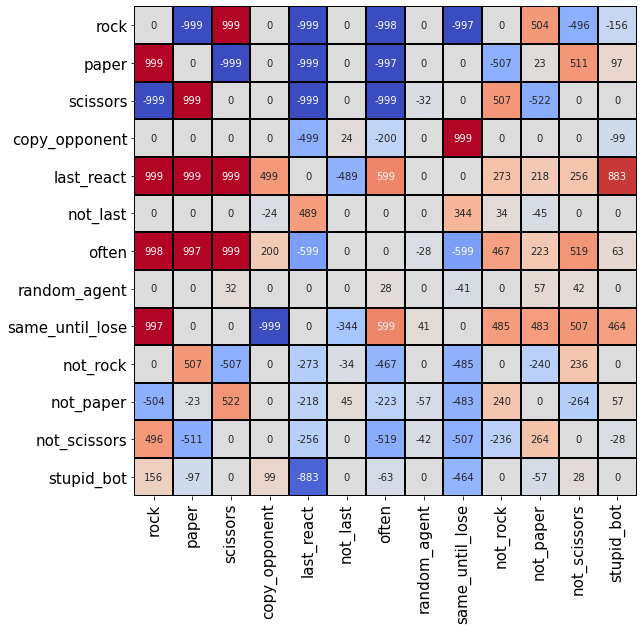

In [20]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', linewidths=1, 
    linecolor='black', fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

Вывод: из тепловой диаграммы выше видно, что наиболее успешными являются агенты last_react, often, same_until_lose. Наименее удачными простейшие rock, paper, scissors.